## Unlocking the data vault: a journey into exploration and insight

<img src="cover-exploring.webp" alt="cover-exploring" width="350">

*packages*

In [1]:
# general
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os, yaml, requests
import numpy as np

# To plot pretty figures
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn-v0_8-whitegrid')

# warnings
import warnings
warnings.filterwarnings('ignore')

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


*functions*

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

*create the connection to the db*

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

*get all the data from the db*

In [4]:
q = """
    select
            *
    from
            kaggle_data.revenue_forecast.data;
"""

df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763


get the null values, if exits

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Number_of_Customers        1000 non-null   int64  
 1   Menu_Price                 1000 non-null   float64
 2   Marketing_Spend            1000 non-null   float64
 3   Cuisine_Type               1000 non-null   object 
 4   Average_Customer_Spending  1000 non-null   float64
 5   Promotions                 1000 non-null   int64  
 6   Reviews                    1000 non-null   int64  
 7   Monthly_Revenue            1000 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 62.6+ KB


make a copy of the raw data

In [6]:
df=df_raw.copy()
df.head(2)

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091


there are the same proportion for all type of cuisine

In [7]:
df_raw['Cuisine_Type'].value_counts()

Cuisine_Type
Japanese    262
American    256
Mexican     250
Italian     232
Name: count, dtype: int64

In [8]:
cols=['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Monthly_Revenue']
df_raw[cols].describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Monthly_Revenue
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,268.724172
std,26.364914,11.278760,5.845586,11.471686,103.982950
min,10.000000,10.009501,0.003768,10.037177,-28.977809
25%,30.000000,20.396828,4.690724,19.603041,197.103642
50%,54.000000,30.860614,10.092047,29.251365,270.213964
75%,74.000000,39.843868,14.992436,39.553220,343.395793
max,99.000000,49.974140,19.994276,49.900725,563.381332


In the following box chart, it's evident that there are no atypical values. However, what's striking is the minimal expenditure on marketing, coupled with the observation that certain restaurants have a notably low customer count.

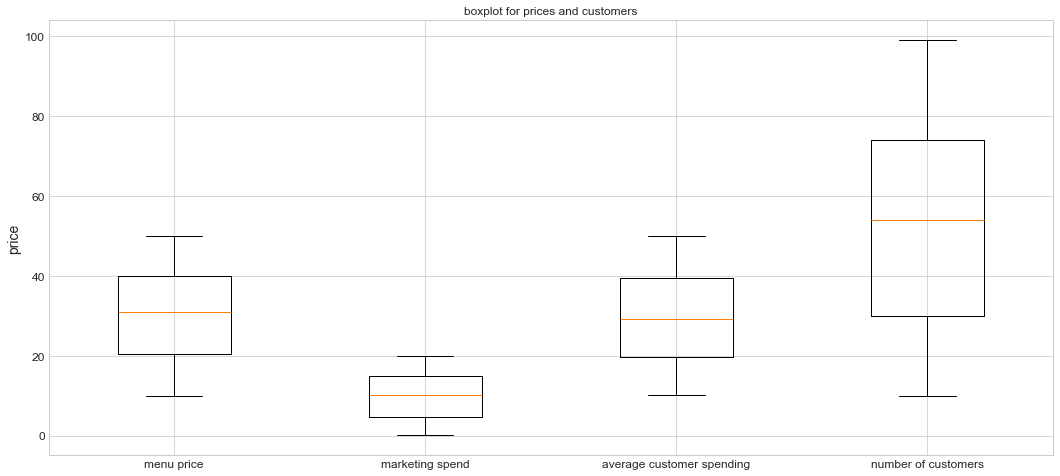

In [9]:
plt.figure(figsize=(18, 8)) 
plt.boxplot([df['Menu_Price'], df['Marketing_Spend'], 
            df['Average_Customer_Spending'], df['Number_of_Customers']])

plt.title('boxplot for prices and customers')
plt.xticks([1, 2, 3, 4], ['menu price', 'marketing spend', 
                          'average customer spending', 'number of customers'])
plt.ylabel('price')
plt.savefig('boxplot_price_customers.png')
plt.show()

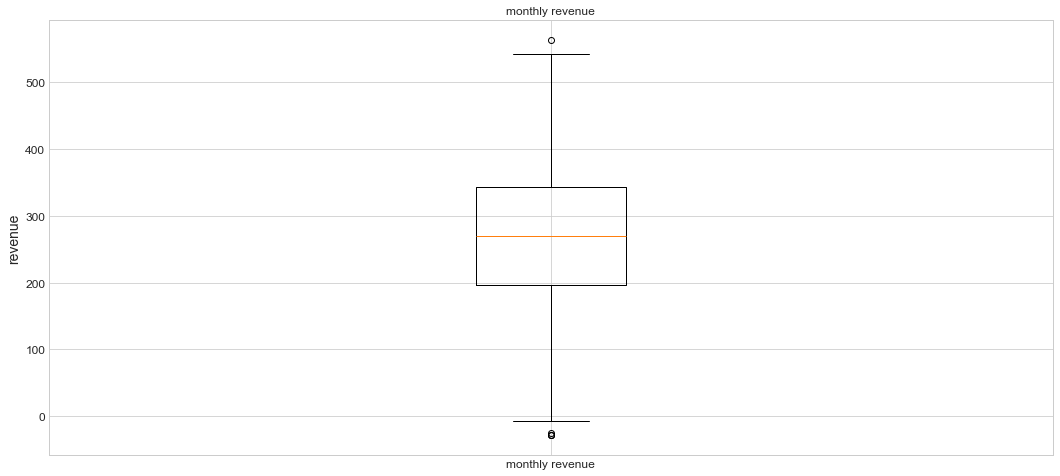

In [10]:
plt.figure(figsize=(18, 8)) 
plt.boxplot(df['Monthly_Revenue'])

plt.title('monthly revenue')
plt.xticks([1], ['monthly revenue'])
plt.ylabel('revenue')
plt.savefig('boxplot_monthly_revenue.png')
plt.show()

In examining the box charts, we find no atypical data in key metrics such as menu prices, marketing spend, average customer spending, and the number of customers. However, a closer look reveals some outliers in monthly revenue, with notably high values that appear somewhat abnormal. To gain a clearer understanding of this anomaly, further exploration of the data is necessary. Additionally, the presence of negative revenue figures raises concerns, suggesting instances where costs surpass income—a scenario that warrants investigation. One plausible hypothesis is that the restaurant is new and thus invests heavily in marketing, anticipating a surge in clientele.

Turning to specific features:

- Menu prices predominantly fall within the range of 20 to 40 dollars, though the influence of cuisine type remains undetermined.
- Marketing expenditure appears disproportionately low compared to menu prices, with no restaurant exceeding a 20-dollar spend.
- Average customer spending mirrors menu prices without notable anomalies, alongside a stable customer count. However, deeper analysis is required to assess the impact of promotions on these metrics and ascertain whether promotions correlate with revenue growth or increased customer visits.

`income and marketing spend`

In [11]:
cols_corr=['Monthly_Revenue', 'Marketing_Spend', 'Menu_Price']
corr_matrix=df[cols_corr].corr()
corr_matrix['Monthly_Revenue'].sort_values(ascending=False)

Monthly_Revenue    1.000000
Marketing_Spend    0.269929
Menu_Price         0.259579
Name: Monthly_Revenue, dtype: float64

Now, considering our initial exploration into the relationship among income, revenue, and pricing, it becomes evident that a positive correlation exists. In other words, when there's an uptick in marketing expenditure and menu prices, revenue tends to rise accordingly. 

While this association isn't overwhelmingly strong, it provides valuable insights. Firstly, we discern that menu pricing doesn't significantly sway sales. Instead, our focus shifts to analyzing customer numbers and average spending per customer. By first determining elasticity and subsequently assessing the influence of the average transaction value on revenue, we gain a deeper understanding of their impacts.

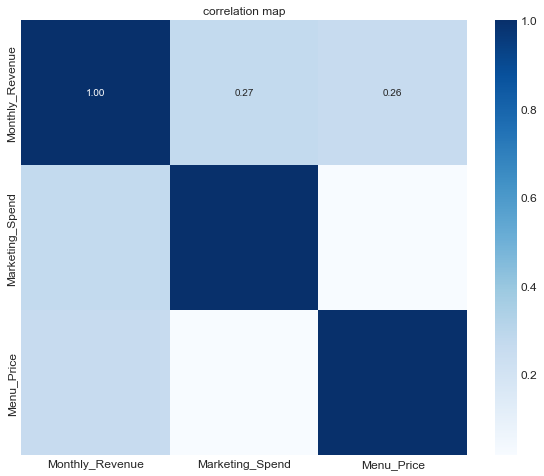

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, 
            cmap='Blues', 
            fmt=".2f")
plt.title('correlation map')
plt.savefig('corr_heatmap.png')
plt.show()

`marketing efficency`

Moving forward, a crucial step would involve calculating the marketing ROI. A high ROI signifies that you're generating more income for every dollar invested in marketing, indicating greater efficiency in your marketing expenditure. Conversely, a low marketing ROI might suggest the need to refine your strategy and marketing spend to enhance its efficiency and amplify the return on your investment.

In [13]:
df['roi_marketing']=round((df['Monthly_Revenue']/df['Marketing_Spend'])*1, 1)
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,roi_marketing
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.91204,27.7


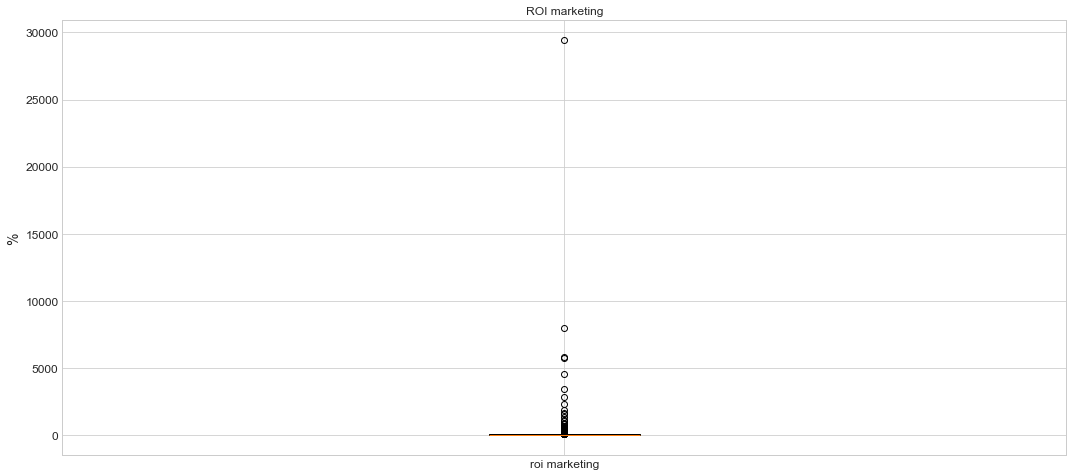

In [14]:
plt.figure(figsize=(18, 8)) 
plt.boxplot(df['roi_marketing'])

plt.title('ROI marketing')
plt.xticks([1], ['roi marketing'])
plt.ylabel('%')
plt.savefig('boxplot_roi_marketing.png')
plt.show()

As depicted in the chart below, Japanese cuisine stands out with the highest revenue. This suggests that perhaps the average menu price for Japanese dishes is also the highest among all cuisine types. Moreover, it's plausible that this particular cuisine type is responsible for the outlier points in the ROI analysis.

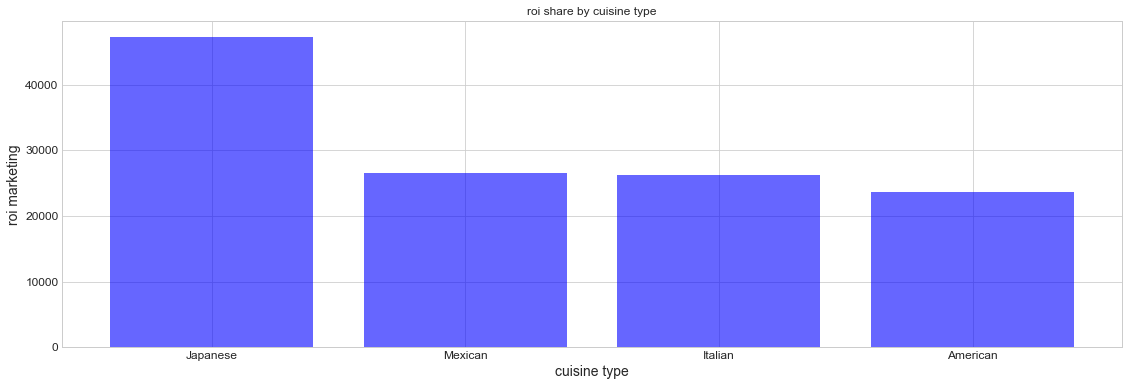

In [15]:
cols=['Cuisine_Type', 'roi_marketing']
summary=df[cols].groupby(by='Cuisine_Type', 
                         as_index=False).agg('sum').sort_values(by='roi_marketing', 
                                                                ascending=False)

plt.figure(figsize=(19, 6))
plt.bar(summary['Cuisine_Type'], 
        summary['roi_marketing'], 
        color='blue', 
        alpha=0.6)

plt.title('roi share by cuisine type')
plt.xlabel('cuisine type')
plt.ylabel('roi marketing')
plt.savefig('roi_cuisine.png')
plt.show()

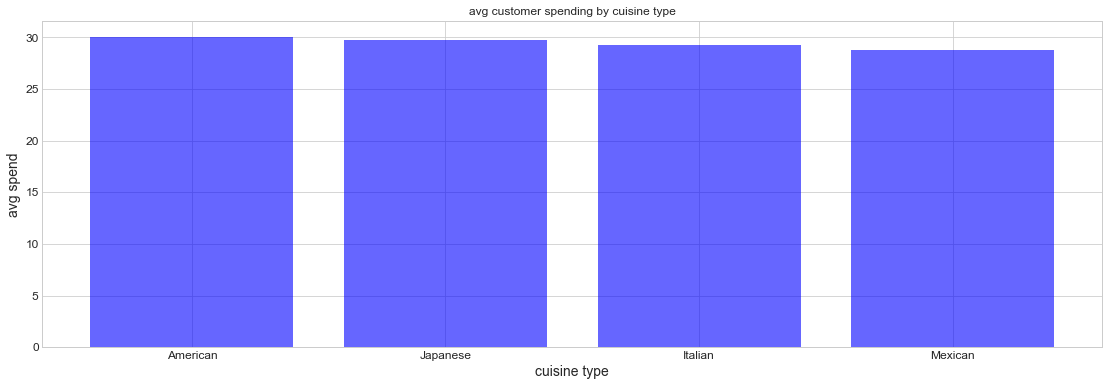

In [16]:
cols=['Average_Customer_Spending', 'Cuisine_Type']
summary=df[cols].groupby(by='Cuisine_Type', 
                         as_index=False).agg('mean').sort_values(by='Average_Customer_Spending', 
                                                                 ascending=False)

plt.figure(figsize=(19, 6))
plt.bar(summary['Cuisine_Type'], 
        summary['Average_Customer_Spending'], 
        color='blue', 
        alpha=0.6)

plt.title('avg customer spending by cuisine type')
plt.xlabel('cuisine type')
plt.ylabel('avg spend')
plt.savefig('avg_spend_cuisine.png')
plt.show()

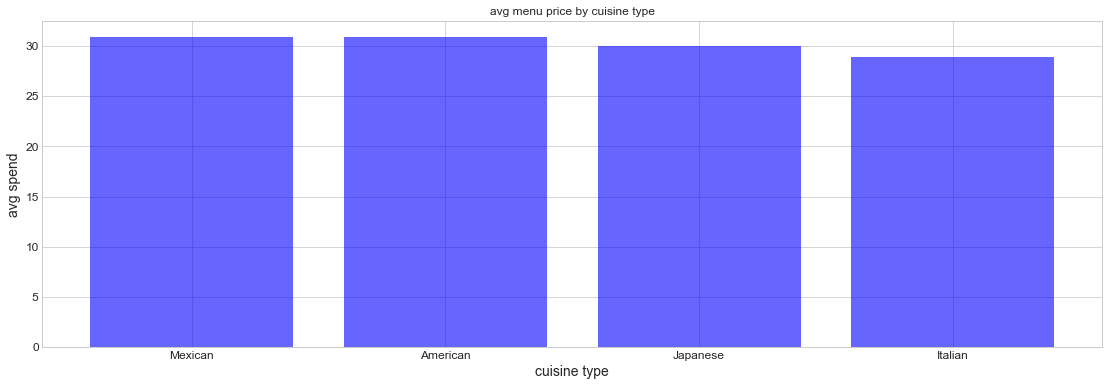

In [17]:
cols=['Menu_Price', 'Cuisine_Type']
summary=df[cols].groupby(by='Cuisine_Type', 
                         as_index=False).agg('mean').sort_values(by='Menu_Price', 
                                                                 ascending=False)

plt.figure(figsize=(19, 6))
plt.bar(summary['Cuisine_Type'], 
        summary['Menu_Price'], 
        color='blue', 
        alpha=0.6)

plt.title('avg menu price by cuisine type')
plt.xlabel('cuisine type')
plt.ylabel('avg spend')
plt.savefig('avg_spend_cuisine.png')
plt.show()

The reality diverges significantly from our earlier assumption that Japanese cuisine commands a higher average menu price. Upon closer examination, it becomes evident that the average customer spending across all cuisine types remains fairly consistent. Surprisingly, the menu prices for Japanese dishes are comparatively lower than those for Mexican cuisine, which appears to be priced at a premium. This unexpected finding prompts a deeper investigation to understand the underlying reasons for this particular behavior.

`promotion impact`

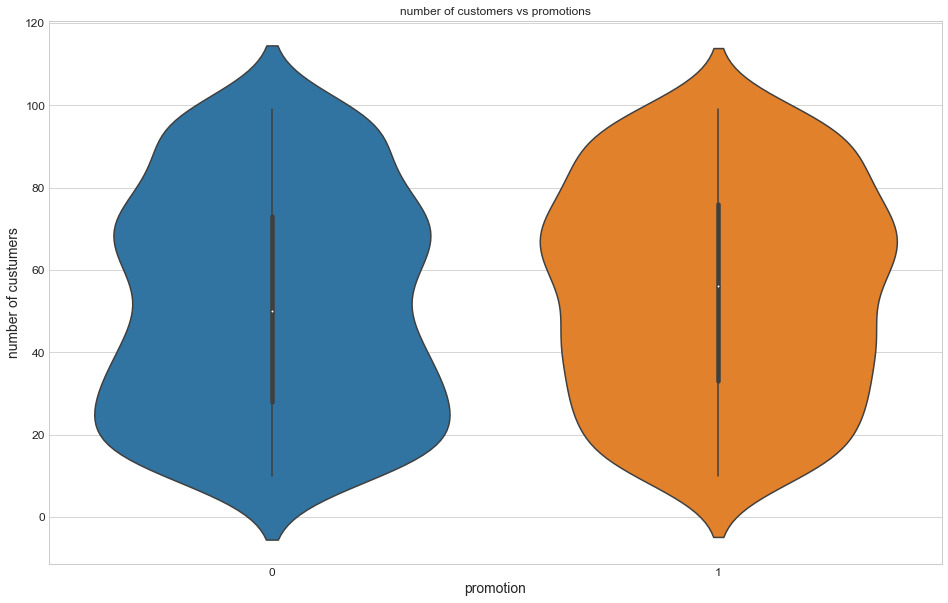

In [18]:
plt.figure(figsize=(16, 10))
sns.violinplot(x = 'Promotions',
               y = 'Number_of_Customers',
               data=df,
               palette='tab10')

plt.title('number of customers vs promotions')
plt.ylabel('number of custumers')
plt.xlabel('promotion')
plt.savefig('violin_customers.png')
plt.show()

In our quest to understand the impact of promotions on customer visits, the violin chart provides valuable insights. Comparing the median points, we observe that when promotions are applied, there's a notable increase in customer numbers compared to periods without promotions. Additionally, the dispersion of customers appears to be more concentrated during promotional periods. This suggests a potential link between promotions and customer turnout, although it's premature to establish causality at this stage. It's important to note that other external factors not captured in the dataset, such as day of the week, holidays, and weather conditions, may also influence customer traffic and warrant consideration in our analysis.

`price impact`

In [19]:
cols=['Menu_Price', 'Cuisine_Type', 'Average_Customer_Spending']
summary=df[cols].groupby(by='Cuisine_Type', 
                         as_index=False).agg('mean').sort_values(by='Menu_Price', 
                                                                 ascending=False)

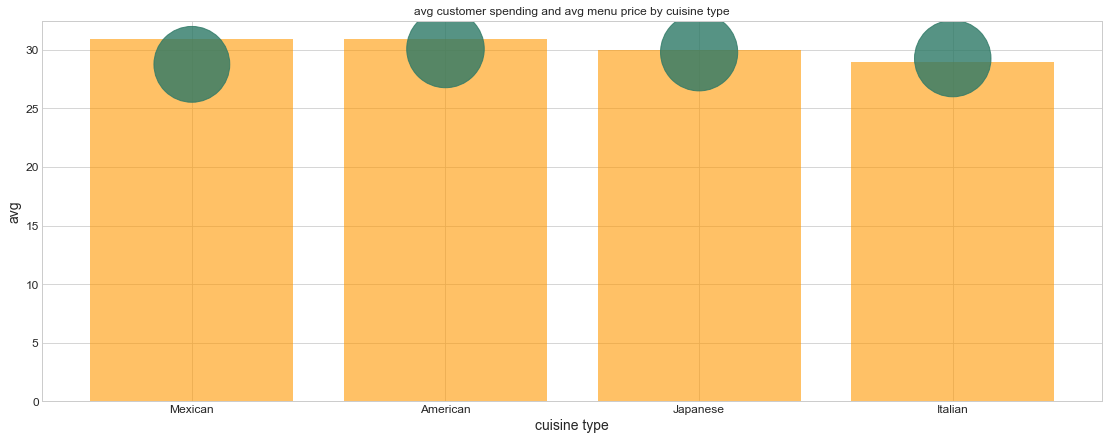

In [20]:
plt.figure(figsize=(19, 7))

plt.bar(summary['Cuisine_Type'], 
        summary['Menu_Price'], 
        color='#FF9800', 
        alpha=0.6, 
        label='avg menu price')

plt.scatter(summary['Cuisine_Type'], 
            summary['Average_Customer_Spending'], 
            s=summary['Average_Customer_Spending']*200, 
            c='#2C7865', 
            alpha=0.8,
            label='avg customer spending')

plt.title('avg customer spending and avg menu price by cuisine type')
plt.xlabel('cuisine type')
plt.ylabel('avg')
plt.savefig('avg_spend_and_price_cuisine.png')
plt.show()

The chart above presents a nuanced view of Japanese cuisine within the market. While it does not feature the most expensive menu or the highest average customer spending, it boasts the highest marketing ROI. However, it's important to note that there is an outlier in the data, urging caution in our conclusions. To formulate the best strategy moving forward, we must delve deeper into the data to understand the preferences and behaviors of different customer segments. Additionally, a comprehensive overview that includes revenue metrics will be essential in aligning our marketing efforts with the broader business objectives. This thorough analysis will ensure that our strategies are both informed and effective.

In [21]:
cols=['Menu_Price', 'Cuisine_Type', 'Average_Customer_Spending', 'Number_of_Customers']
summary=df[cols].groupby(by='Cuisine_Type', 
                         as_index=False).agg({'Menu_Price':'mean',
                                              'Average_Customer_Spending':'mean',
                                              'Number_of_Customers':'sum'}).sort_values(by='Menu_Price', 
                                                                                        ascending=False)

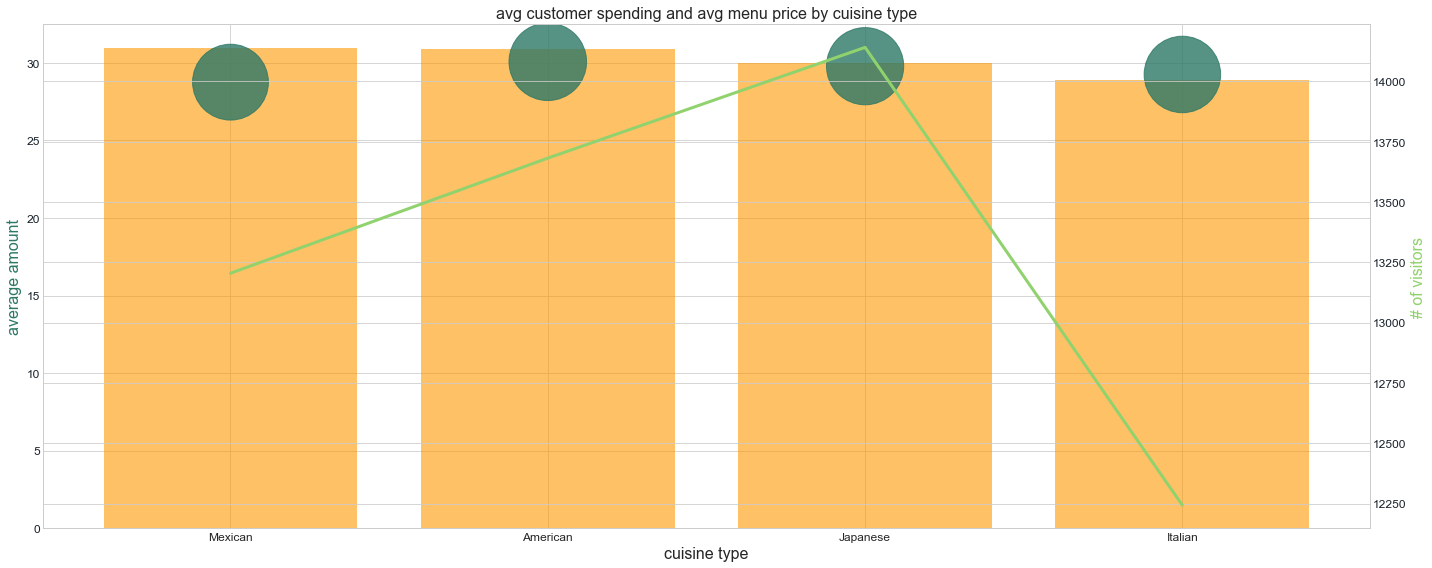

In [22]:
fig, ax1 = plt.subplots(figsize=(20, 8))

ax1.set_xlabel('cuisine type', fontsize=16)
ax1.set_ylabel('average amount', color='#2C7865', fontsize=16)

ax1.bar(summary['Cuisine_Type'], 
        summary['Menu_Price'], 
        alpha=0.6,
        color='#FF9800')

ax1.scatter(summary['Cuisine_Type'], 
            summary['Average_Customer_Spending'], 
            s=summary['Average_Customer_Spending']*200, 
            c='#2C7865', 
            alpha=0.8,
            label='avg customer spending')

ax1.tick_params(axis='y', labelcolor='#17202A')


ax2 = ax1.twinx()
ax2.set_ylabel('# of visitors', color='#90D26D',  fontsize=16)
ax2.plot(summary['Cuisine_Type'], 
         summary['Number_of_Customers'],
         linewidth=3,
         color='#90D26D')
ax2.tick_params(axis='y', labelcolor='#17202A')

plt.title('avg customer spending and avg menu price by cuisine type', fontsize=16)
fig.tight_layout()
plt.savefig('avg_spend_and_price_and_visitors_cuisine.png')
plt.show()

The latest chart offers valuable insights into the visitor counts at our establishments, with Japanese food restaurants seeing a notable increase in patronage. This trend may be influenced by a variety of factors, such as prime locations, compelling promotions, or substantial marketing investments. Additionally, there are indications that pricing strategies are also impacting customer attendance. Understanding these dynamics is crucial for optimizing our approach to attract and retain more customers efficiently.

`relation among the revenue, the number of visitors and reviews`

In [23]:
cols=['Cuisine_Type', 'Monthly_Revenue', 'Number_of_Customers', 'Reviews']
summary=df[cols].groupby(by='Cuisine_Type', 
                         as_index=False).agg({'Monthly_Revenue':'mean',
                                              'Reviews':'sum',
                                              'Number_of_Customers':'sum'})

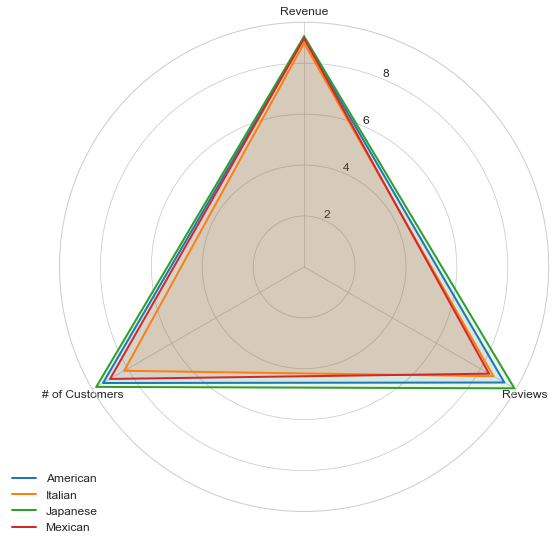

In [24]:
labels = np.array(['Revenue', 'Reviews', '# of Customers'])
cuisine_type=['American', 'Italian', 'Japanese', 'Mexican']
data = np.array(summary)[:, 1:]

max_scales = np.array([30, 1400, 1500])  

data_normalized = data / max_scales

data_normalized = np.concatenate((data_normalized, data_normalized[:, 0:1]), axis=1)  # Cerrar el círculo
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(19, 9), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

for i in range(data_normalized.shape[0]):
    ax.plot(angles, data_normalized[i], linewidth=2, linestyle='solid', label=cuisine_type[i])
    ax.fill(angles, data_normalized[i], alpha=0.1)

plt.xticks(angles[:-1], labels)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
plt.savefig('radar_chart.png')
plt.show()

The radar chart provides some intriguing insights into our culinary offerings. Consistent with previous data, Japanese cuisine generates the highest average monthly revenue, although the figures are quite similar across all types of cuisines. Interestingly, Mexican food, despite not garnering a large number of reviews, maintains a robust visitor count. On the other hand, Italian cuisine, which has slightly more reviews than Mexican, surprisingly sees fewer customers, even with comparable menu prices. This suggests that other variables such as promotions, location, or service quality might be influencing these trends. Currently, we can only speculate whether promotions directly affect customer turnout. In the upcoming sections, we will engage in causal inference analysis to determine the impact of these factors more definitively.

### `insights`

*Distribution Data Analysis:*
- The charts reveal mostly typical values across various features with notable exceptions in the revenue data. Japanese cuisine displays extreme revenue values, including some restaurants experiencing negative revenue, indicating financial losses. Conversely, most menu prices and average customer spending lie within the \\$20 to \\$40 range, with minimal marketing expenditure across all establishments.

*Revenue Correlation Insights:*
- Analysis indicates a positive correlation between revenue and both marketing spend and menu price. This suggests that higher menu prices and increased marketing investments may lead to an uptick in revenue, although the correlations are modest and not necessarily indicative of causation.

*Marketing ROI and Cuisine Type:*
- Japanese cuisine consistently shows the highest marketing ROI, possibly skewed by outliers. This suggests that Japanese restaurants may be more effective in managing marketing efforts like promotions. However, this does not imply causality. Notably, the Japanese menu is not the priciest, nor does it attract the highest spending per customer.

*Impact of Promotions:*
- Violin chart analysis demonstrates that promotions significantly impact customer numbers, with a noticeable uptick in visitors during promotional periods. This could suggest a market responsive to price changes (elastic market), although it remains speculative without more detailed information.

*Price Versus Customer Numbers:*
- There appears to be no direct correlation between menu prices and customer volume. For instance, despite having lower menu prices, Italian cuisine does not attract more customers compared to American cuisine, which has higher prices and more visitors. Location may play a role in this dynamic, but this remains an assumption.

*Radar Chart and Customer Insights:*
- The radar chart highlights an interesting trend: despite Italian cuisine receiving slightly more reviews than Mexican cuisine, the latter maintains a higher customer count, possibly due to effective promotional strategies.


**Current Insights:**
- Reviews do not necessarily translate to increased visitor numbers.
- Japanese cuisine sites exhibit the best performance in terms of ROI.
- Menu pricing appears to have a minimal impact on demand, suggesting market inelasticity.
- Promotions significantly influence customer numbers, enhancing restaurant visitation despite low marketing expenditure.

These observations underscore the complex interplay of factors affecting restaurant performance and customer behavior.